In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [2]:
# Cargado de dataset
df = pd.read_csv('./data/data_con_sentimientos.csv')

# Convertir film_avg_rate a float
df['film_avg_rate'] = df['film_avg_rate'].str.replace(',', '.').astype(float)

In [3]:
def preprocess_data(df):

    # Agregar features a nivel de película
    movie_features = df.groupby('film_name').agg({
        'film_avg_rate': 'mean',
        'review_rate': 'mean',
        'positivo': 'mean',
        'neutro': 'mean',
        'negativo': 'mean'
    }).reset_index()
    
    # Normalizar features
    scaler = MinMaxScaler()
    features = ['film_avg_rate', 'review_rate', 'positivo', 'neutro', 'negativo']
    movie_features[features] = scaler.fit_transform(movie_features[features])
    
    return movie_features, scaler


#    Modelo autoencoder y el modelo de embedding.
def create_model(input_dim):

    input_layer = Input(shape=(input_dim,))
    
    # Encoder
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(16, activation='relu')(encoded)
    
    # Embedding layer
    embedding = Dense(8, activation='relu', name='embedding')(encoded)
    
    # Decoder
    decoded = Dense(16, activation='relu')(embedding)
    decoded = Dense(32, activation='relu')(decoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    # Crear modelos
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    embedding_model = Model(inputs=input_layer, outputs=embedding)
    
    return autoencoder, embedding_model



# Obtiene recomendaciones para una película específica.
def get_recommendations(movie_name, movie_features, embedding_model, n_recommendations=5):

    movie_idx = movie_features[movie_features['film_name'] == movie_name].index[0]
    
    features = ['film_avg_rate', 'review_rate', 'positivo', 'neutro', 'negativo']
    all_embeddings = embedding_model.predict(movie_features[features])
    
    movie_embedding = all_embeddings[movie_idx].reshape(1, -1)
    similarities = cosine_similarity(movie_embedding, all_embeddings)[0]
    
    similar_indices = similarities.argsort()[::-1][1:n_recommendations+1]
    
    recommendations = pd.DataFrame({
        'movie': movie_features.iloc[similar_indices]['film_name'],
        'similarity_score': similarities[similar_indices]
    })
    
    return recommendations

def evaluate_model(X_train, X_test, autoencoder, history):
    # Predicciones
    train_predictions = autoencoder.predict(X_train)
    test_predictions = autoencoder.predict(X_test)
    
    # Métricas básicas
    train_mse = mean_squared_error(X_train, train_predictions)
    test_mse = mean_squared_error(X_test, test_predictions)
    train_mae = mean_absolute_error(X_train, train_predictions)
    test_mae = mean_absolute_error(X_test, test_predictions)
    
    # Métricas adicionales
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_r2 = r2_score(X_train, train_predictions)
    test_r2 = r2_score(X_test, test_predictions)
    
    print("\nMétricas de Entrenamiento:")
    print(f"MSE: {train_mse:.4f}")
    print(f"RMSE: {train_rmse:.4f}")
    print(f"MAE: {train_mae:.4f}")
    print(f"R² Score: {train_r2:.4f}")
    
    print("\nMétricas de Validación:")
    print(f"MSE: {test_mse:.4f}")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"R² Score: {test_r2:.4f}")
    
    
    # Visualización del entrenamiento
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
def train_recommender(df, epochs=50, batch_size=32):
    # Preprocesar datos
    movie_features, scaler = preprocess_data(df)
    
    # Preparar features
    features = ['film_avg_rate', 'review_rate', 'positivo', 'neutro', 'negativo']
    X = movie_features[features].values
    
    # Dividir datos
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    
    # Crear y compilar modelo
    autoencoder, embedding_model = create_model(input_dim=len(features))
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # Entrenar modelo
    print("Iniciando entrenamiento...")
    history = autoencoder.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, X_test),
        verbose=1
    )
    
    # Evaluar modelo
    evaluate_model(X_train, X_test, autoencoder, history)
    
    return embedding_model, movie_features

Iniciando entrenamiento...
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2429 - val_loss: 0.1512
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1008 - val_loss: 0.0497
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0461 - val_loss: 0.0410
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0379 - val_loss: 0.0296
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239 - val_loss: 0.0201
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205 - val_loss: 0.0183
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0186 - val_loss: 0.0162
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - val_loss: 0.0157
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 - val_loss: 0.0149
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.0139
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142 - val_loss: 0.0135
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

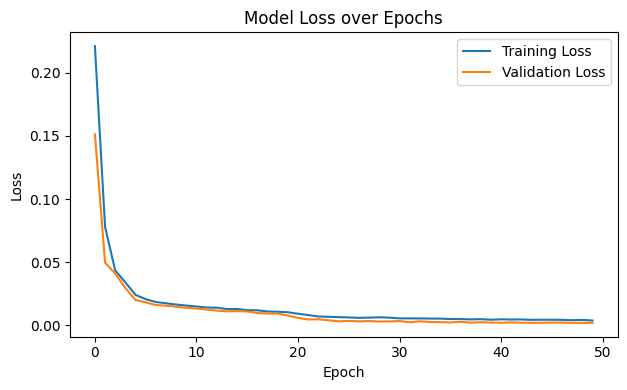

In [5]:
model, movie_features = train_recommender(df)


In [6]:
# Obtener recomendaciones para una película específica
movie_name = movie_features['film_name'].iloc[1]
recommendations = get_recommendations(movie_name, movie_features, model)
print(f"\nRecomendaciones para '{movie_name}':")
print(recommendations)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Recomendaciones para '10 días de un buen hombre ':
                            movie  similarity_score
14        Accidente (Serie de TV)          0.999388
202  El elegido (Miniserie de TV)          0.997524
212      El glamour (Serie de TV)          0.997065
245          El robo a Mussolini           0.995367
495       Maleantes (Serie de TV)          0.995254


In [7]:
import tkinter as tk
from tkinter import ttk
import math

class MovieRecommenderGUI:
    def __init__(self, movie_features, model):
        self.root = tk.Tk()
        self.root.title("Sistema de recomendación de películas")
        self.root.geometry("800x600")
        
        # Guardar el modelo y features
        self.movie_features = movie_features
        self.model = model
        
        # Variables de paginación
        self.current_page = 1
        self.movies_per_page = 5
        self.total_movies = len(movie_features)
        self.total_pages = math.ceil(self.total_movies / self.movies_per_page)
        
        # Crear el frame principal
        self.main_frame = ttk.Frame(self.root, padding="10")
        self.main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        # Crear frames para películas
        self.movie_frames = []
        for i in range(self.movies_per_page):
            frame = ttk.Frame(self.main_frame, padding="5")
            frame.grid(row=i, column=0, sticky=(tk.W, tk.E), pady=5)
            self.movie_frames.append(frame)
        
        # Crear frame para navegación
        self.nav_frame = ttk.Frame(self.main_frame, padding="5")
        self.nav_frame.grid(row=self.movies_per_page, column=0, pady=10)
        
        # Botones de navegación
        ttk.Button(self.nav_frame, text="Anterior", command=self.prev_page).grid(row=0, column=0, padx=5)
        self.page_label = ttk.Label(self.nav_frame, text=f"Página {self.current_page} de {self.total_pages}")
        self.page_label.grid(row=0, column=1, padx=20)
        ttk.Button(self.nav_frame, text="Siguiente", command=self.next_page).grid(row=0, column=2, padx=5)
        
        # Mostrar primera página
        self.update_page()
        
    def update_page(self):
        # Limpiar frames existentes
        for frame in self.movie_frames:
            for widget in frame.winfo_children():
                widget.destroy()
        
        # Calcular índices de películas para la página actual
        start_idx = (self.current_page - 1) * self.movies_per_page
        end_idx = min(start_idx + self.movies_per_page, self.total_movies)
        
        # Mostrar películas
        for i, movie_idx in enumerate(range(start_idx, end_idx)):
            movie_name = self.movie_features.iloc[movie_idx]['film_name']
            
            # Crear label para el nombre de la película
            ttk.Label(self.movie_frames[i], text=movie_name, wraplength=600).grid(row=0, column=0, sticky=tk.W)
            
            # Crear botón de recomendaciones
            ttk.Button(
                self.movie_frames[i], 
                text="Ver recomendaciones",
                command=lambda m=movie_name: self.show_recommendations(m)
            ).grid(row=1, column=0, pady=5)
        
        # Actualizar label de página
        self.page_label.config(text=f"Página {self.current_page} de {self.total_pages}")
    
    def prev_page(self):
        if self.current_page > 1:
            self.current_page -= 1
            self.update_page()
    
    def next_page(self):
        if self.current_page < self.total_pages:
            self.current_page += 1
            self.update_page()
    
    def show_recommendations(self, movie_name):
        # Crea ventana para recomendaciones
        rec_window = tk.Toplevel(self.root)
        rec_window.title(f"Recomendaciones para {movie_name}")
        rec_window.geometry("600x400")
        
        # Frame principal
        main_frame = ttk.Frame(rec_window, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        # Título
        ttk.Label(
            main_frame, 
            text=f"Películas similares a:\n{movie_name}"
        ).grid(row=0, column=0, pady=10)
        
        # Obtener recomendaciones
        recommendations = get_recommendations(movie_name, self.movie_features, self.model)
        
        # Muestra recomendaciones
        for idx, (_, row) in enumerate(recommendations.iterrows()):
            rec_frame = ttk.Frame(main_frame, padding="5")
            rec_frame.grid(row=idx+1, column=0, sticky=(tk.W, tk.E), pady=5)
            
            ttk.Label(
                rec_frame, 
                text=f"{idx+1}. {row['movie']}"
            ).grid(row=0, column=0, sticky=tk.W)
        
        # Botón para cerrar
        ttk.Button(
            main_frame, 
            text="Cerrar", 
            command=rec_window.destroy
        ).grid(row=len(recommendations)+1, column=0, pady=10)
    
    def run(self):
        self.root.mainloop()


def launch_gui(model, movie_features):
    app = MovieRecommenderGUI(movie_features, model)
    app.run()

In [8]:
launch_gui(model, movie_features)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
